In [1]:
#reading raw rr interval vs sleep grade into a dataframe:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
rri_sleep_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Driver_Drowsiness/RRinterval_SleepStages_Dataset.csv',)
rri_sleep_df.tail()

,RR Interval,Sleep Stage
49668,[0.1484375 0.29296875 0.14453125 0.17578125 0...,0
49669,[0.15234375 0.29296875 0.1875 0.22265625 0...,0
49670,[0.33203125 0.23046875 0.20703125 0.296875 0...,0
49671,[0.4375 0.296875 0.07421875 0.12109375 0...,0
49672,[0.28515625 0.21484375 0.08203125 0.296875 0...,0


In [2]:
#writing a function to process the rri_sleep_df rr intervals (initially strings)
def process_intervals(rr_string_interval):
  nums = []
  for char in rr_string_interval.split():
    if char[0] == '[':
        char = char[1:]
    elif char[-1] == ']':
        char = char[:-1]
    try:
        num = eval(char)
        nums.append(num)
    except:
        pass
  return nums

In [3]:
#making list for rr inteval/sleep stage

rr_intervals,sleep_stages = [],[]

for row_index in range(len(rri_sleep_df)):
  sample = rri_sleep_df.iloc[row_index]
  rr_string_interval = sample['RR Interval']
  rr_intervals.append(process_intervals(rr_string_interval))
  sleep_stages.append(float((sample['Sleep Stage'])))


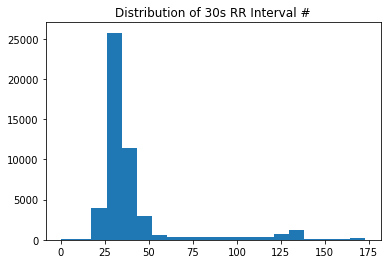

Median 30s RR Interval #: 33
30s RR Interval # Standard Deviation: 26.051248622965854


In [4]:
#plotting distrbution of rr_interval array lenghts:

import statistics as stats

rr_interval_lengths = [len(rr_interval) for rr_interval in rr_intervals]


plt.hist(rr_interval_lengths,bins=20)
plt.title('Distribution of 30s RR Interval #')
plt.show()

print(f'Median 30s RR Interval #: {stats.median(rr_interval_lengths)}')
print(f'30s RR Interval # Standard Deviation: {stats.stdev(rr_interval_lengths)}')

In [64]:
#calculating % of samples w/i +-1 SD of the median
print(len([rr_interval_length for rr_interval_length in rr_interval_lengths if rr_interval_length in range(33-10,33+10+1)]))
len((rr_interval_lengths))

40293


49673

In [65]:
#clipping valid rr interval range to 7 --> 59 will ensure model is generalizable to 90% of the population
valid_rr_intervals = [rr_interval for rr_interval in rr_intervals if len(rr_interval) in range(33-10,33+10+1)]
valid_sleep_stage_indicies = [index for index,rr_interval in enumerate(rr_intervals) if len(rr_interval) in range(33-10,33+10+1)]
valid_sleep_stages = [sleep_stages[index] for index in valid_sleep_stage_indicies]
#adjusting sleep_stages list for binary classification between awake(0) and sleep (1-5)
valid_sleep_stages = np.array(valid_sleep_stages)
valid_sleep_stages[valid_sleep_stages>=1] = 1
print(len(valid_rr_intervals))
print(len(valid_sleep_stages))

40293
40293


In [66]:
#noramlizing/scaling all rr intervals
from sklearn.preprocessing import RobustScaler

clean_rr_intervals = [0]*len(valid_rr_intervals)

for index,dirty_rr_interval in enumerate(valid_rr_intervals):
  transformer = RobustScaler().fit(np.array(dirty_rr_interval).reshape(-1,1))
  transformed_arr = transformer.transform(np.array(dirty_rr_interval).reshape(-1,1))
  transformed_arr = transformed_arr.T
  clean_rr_intervals[index] = transformed_arr.tolist()[0]

In [67]:
#padding zeros to end of smaller rr interval arrays
max_rr_interval_num = max([len(rr_interval) for rr_interval in clean_rr_intervals])
for rr_interval in clean_rr_intervals:
  if len(rr_interval)<max_rr_interval_num:
    add_zero_num = max_rr_interval_num-len(rr_interval)
    for _ in range(add_zero_num):
      rr_interval.append(0)
#renaming clearn_rr_intervals --> RR_intervals
RR_intervals = clean_rr_intervals
RR_intervals = np.array(RR_intervals)
print(RR_intervals.shape)

(40293, 43)


In [82]:
#pulling function that makes recurrance plots on passed series data
from sklearn import metrics

def recurrence_plot(s, eps=None, steps=None):
  if eps==None: eps=0.1
  if steps==None: steps=10
  d = metrics.pairwise.pairwise_distances(s)
  d = np.floor(d / eps)
  d[d > steps] = steps
  #Z = squareform(d)
  return d

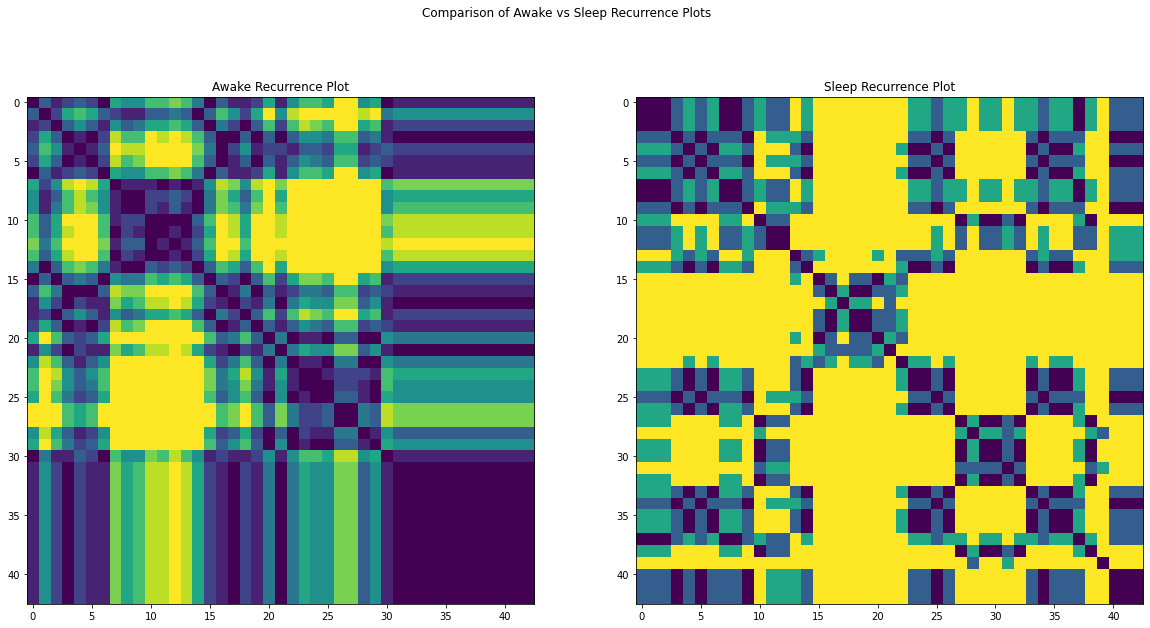

In [83]:
#pulling an awake vs sleep stage index

#making a temp list so we can pull indices where person was awake vs in varying degrees of sleep
valid_sleep_stages_list = list(valid_sleep_stages)
awake_indicies = [index for index,sleep_stage in enumerate(valid_sleep_stages_list) if sleep_stage==0]
sleep_indicies = [index for index,sleep_stage in enumerate(valid_sleep_stages_list) if sleep_stage==1]

#making a recurrance plot of randomly chosen awake vs sleep
rand_wake_index = np.random.choice(awake_indicies)
rand_sleep_index = np.random.choice(sleep_indicies)

awake_rp = recurrence_plot(RR_intervals[rand_wake_index,:].reshape(-1,1))
sleep_rp = recurrence_plot(RR_intervals[rand_sleep_index,:].reshape(-1,1))

fig, axs = plt.subplots(1,2,figsize=(20,10))
fig.suptitle('Comparison of Awake vs Sleep Recurrence Plots')
axs[0].imshow(awake_rp)
axs[0].set_title('Awake Recurrence Plot')
axs[1].imshow(sleep_rp)
axs[1].set_title('Sleep Recurrence Plot')
fig.show()

In [84]:
from sklearn.preprocessing import normalize
#applying the rp function so each interval so we can create our X database
X_data = np.empty((40293,43,43))

for index in range(X_data.shape[0]):
  RR_interval = RR_intervals[index].reshape(-1,1)
  interval_rp = recurrence_plot(RR_interval)
  interval_rp = normalize(interval_rp)
  X_data[index,:,:] = interval_rp
print(X_data.shape)

(40293, 43, 43)


In [85]:
#test-train splitting our data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, valid_sleep_stages, test_size=0.1, shuffle=True)
#reshaping x vectors to be 4d
x_train = X_train.reshape(X_train.shape[0], 43,43,1)
x_test = X_test.reshape(X_test.shape[0], 43,43,1)

In [89]:
#building CNN to classify between awake vs sleep
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from keras import metrics
from keras import optimizers

model = Sequential(name='Sleep_Classifier_v1')

model.add(Conv2D(filters=16,kernel_size=2,strides=(1, 1),padding='valid',activation='relu',input_shape=(43,43,1), data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid'))
model.add(Dropout(0.1))
model.add(layers.Conv2D(filters=32,kernel_size=2,strides=(1, 1),padding='valid',activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2),padding='valid'))
model.add(Dropout(0.1))
model.add(layers.Conv2D(filters=64,kernel_size=2,strides=(1, 1),padding='valid',activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2),padding='valid'))
model.add(Dropout(0.1))  
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='ADAM',metrics=['accuracy'])
model.summary()

Model: "Sleep_Classifier_v1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_89 (Conv2D)           (None, 42, 42, 16)        80        
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 21, 21, 16)        0         
_________________________________________________________________
dropout_144 (Dropout)        (None, 21, 21, 16)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 20, 20, 32)        2080      
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_145 (Dropout)        (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 9, 9, 64)  

Epoch 1/20
1077/1077 [==============================] - 5s 4ms/step - loss: 0.5560 - accuracy: 0.7493 - val_loss: 0.5441 - val_accuracy: 0.7624
Epoch 2/20
1077/1077 [==============================] - 4s 4ms/step - loss: 0.5426 - accuracy: 0.7494 - val_loss: 0.5198 - val_accuracy: 0.7624
Epoch 3/20
1077/1077 [==============================] - 4s 4ms/step - loss: 0.5388 - accuracy: 0.7487 - val_loss: 0.5158 - val_accuracy: 0.7607
Epoch 4/20
1077/1077 [==============================] - 4s 4ms/step - loss: 0.5310 - accuracy: 0.7506 - val_loss: 0.5108 - val_accuracy: 0.7602
Epoch 5/20
1077/1077 [==============================] - 4s 4ms/step - loss: 0.5317 - accuracy: 0.7481 - val_loss: 0.5065 - val_accuracy: 0.7613
Epoch 6/20
1077/1077 [==============================] - 4s 4ms/step - loss: 0.5247 - accuracy: 0.7552 - val_loss: 0.5204 - val_accuracy: 0.7552
Epoch 7/20
1077/1077 [==============================] - 4s 4ms/step - loss: 0.5207 - accuracy: 0.7535 - val_loss: 0.5093 - val_accuracy:

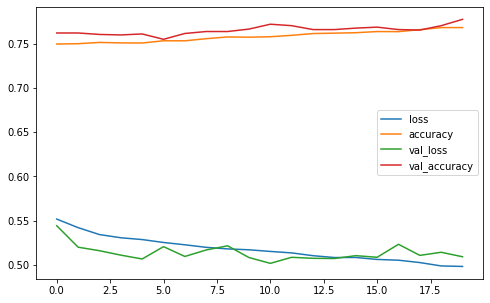

126/126 [==============================] - 0s 2ms/step - loss: 0.5244 - accuracy: 0.7494
test loss, test acc: [0.5243821144104004, 0.7493796348571777]


In [90]:
#training model
history = model.fit(x_train, y_train, epochs=20, validation_split=0.05, batch_size=32,shuffle=True)

#plotting history
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

#testing model
results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)

In [52]:
#building CNN to classify between awake vs sleep
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from keras import metrics
from keras import optimizers

model = Sequential(name='Sleep_Classifier_v2')

model.add(Conv2D(filters=16,kernel_size=2,strides=(1, 1),padding='valid',activation='relu',input_shape=(59,59,1), data_format='channels_last'))
model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2),padding='valid'))
model.add(Dropout(0.1)) 
model.add(layers.Conv2D(filters=32,kernel_size=2,strides=(1, 1),padding='valid',activation='relu'))
model.add(Dropout(0.1)) 
model.add(layers.Conv2D(filters=64,kernel_size=2,strides=(1, 1),padding='valid',activation='relu'))
model.add(Dropout(0.1)) 
model.add(layers.Conv2D(filters=128,kernel_size=2,strides=(1, 1),padding='valid',activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2),padding='valid'))
model.add(Dropout(0.1))  
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='ADAM',metrics=['accuracy'])
model.summary()

Model: "Sleep_Classifier_v2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 58, 58, 16)        80        
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 29, 29, 16)        0         
_________________________________________________________________
dropout_92 (Dropout)         (None, 29, 29, 16)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 28, 28, 32)        2080      
_________________________________________________________________
dropout_93 (Dropout)         (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 27, 27, 64)        8256      
_________________________________________________________________
dropout_94 (Dropout)         (None, 27, 27, 64)

Epoch 1/20
964/964 [==============================] - 8s 7ms/step - loss: 0.5587 - accuracy: 0.7471 - val_loss: 0.5529 - val_accuracy: 0.7431
Epoch 2/20
964/964 [==============================] - 7s 7ms/step - loss: 0.5385 - accuracy: 0.7552 - val_loss: 0.5409 - val_accuracy: 0.7431
Epoch 3/20
964/964 [==============================] - 7s 7ms/step - loss: 0.5322 - accuracy: 0.7546 - val_loss: 0.5468 - val_accuracy: 0.7387
Epoch 4/20
964/964 [==============================] - 7s 7ms/step - loss: 0.5250 - accuracy: 0.7559 - val_loss: 0.5329 - val_accuracy: 0.7439
Epoch 5/20
964/964 [==============================] - 7s 7ms/step - loss: 0.5233 - accuracy: 0.7544 - val_loss: 0.5310 - val_accuracy: 0.7477
Epoch 6/20
964/964 [==============================] - 7s 7ms/step - loss: 0.5139 - accuracy: 0.7608 - val_loss: 0.5308 - val_accuracy: 0.7469
Epoch 7/20
964/964 [==============================] - 7s 7ms/step - loss: 0.5153 - accuracy: 0.7588 - val_loss: 0.5340 - val_accuracy: 0.7486
Epoch 

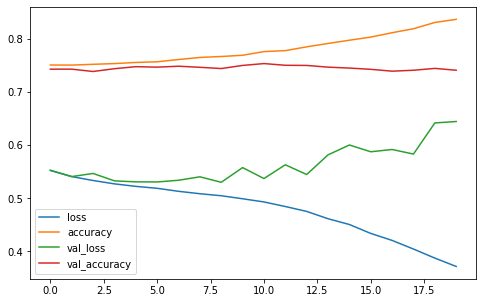

189/189 [==============================] - 1s 3ms/step - loss: 0.6422 - accuracy: 0.7457
test loss, test acc: [0.6421728730201721, 0.7456982135772705]


In [53]:
#training model
history = model.fit(x_train, y_train, epochs=20, validation_split=0.1, batch_size=32,shuffle=True)

#plotting history
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

#testing model
results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)